# Nelder-Mead algorithm

## Imports

In [138]:
%load_ext autoreload
%autoreload

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
from nelder_mead import NelderMeadOptimizer
from IPython.display import Image

sns.set(style="darkgrid", font_scale=1.4)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Defining vectorized version of a function

Below is a vectorized version of a function (we would prefer a vectorized one because we care about the performance, don't we?)

In [103]:
def f(ts):
    """
    Function for optimization
    
    Args:
        ts: numpy array of shape (a, 2) -- arguments of a function
        
    Returns:
        numpy array of shape (a,) -- values of function at different points 
    """
    # Split the input data into x and y components for the sake of simplifying the code
    xs = ts[..., 0]
    ys = ts[..., 1]
    
    return np.sin(ys) * np.exp(np.square(1 - np.cos(xs))) + np.cos(xs) * np.exp(np.square(1 - np.sin(ys))) + np.square(xs - ys)


Let's plot our function

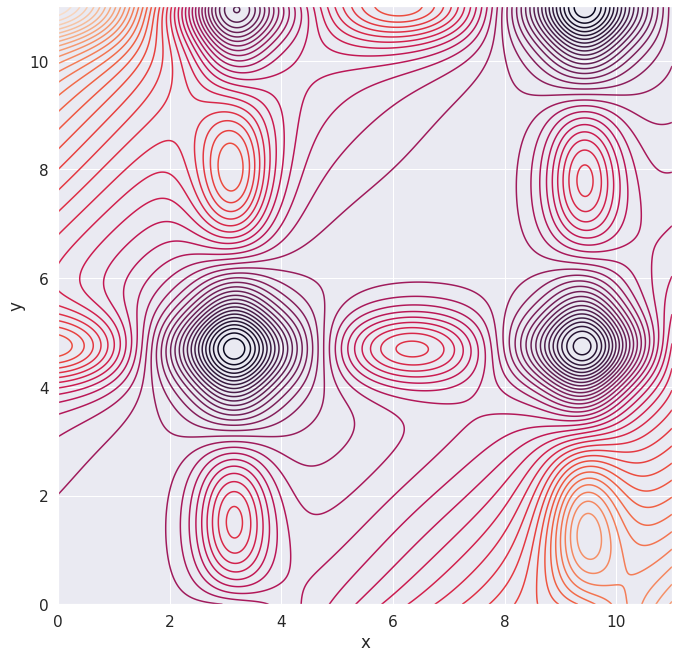

In [104]:
fr = 0
to = 11
step = 0.01
ts = np.mgrid[fr:(to + step):step, fr:(to+step):step].reshape(2,-1).T

xs = np.arange(fr, to + step, step)
ys = np.arange(fr, to + step, step)
size = xs.size
fs = f(ts).reshape((size,size)).T

plt.figure(figsize=(11, 11))
plt.xlabel("x")
plt.ylabel("y")
plt.contour(xs, ys, fs, levels=50)

Now, I imagine, we're finally ready to try out our shiny new optimizer. Let's run it:

In [105]:
opt = NelderMeadOptimizer(log_simplices=True)  # Enable logging to create a stunning plot of converging simplices 
                                               # later
    
initial_simplex = np.array([[0.0, 0.0],
                            [0.0, 11.0],
                            [11.0, 0.0]])
optimum = opt.minimize(f, initial_simplex, max_iterations=50, vartol=1e-4)
print("Optimal point seems to be", optimum)

Optimal point seems to be [3.14512039 4.6988869 ]


Now let's look at the way the simplices were converging:

In [142]:
fig = plt.figure(figsize=(11, 11), dpi=100)
ax = plt.axes(xlim=(0, 11), ylim=(0, 11))
plt.xlabel("x")
plt.ylabel("y")

cur_best = ax.scatter([], [], marker='*', color="lightseagreen", zorder=102)
cur_path, = ax.plot([], [], color="lightseagreen", zorder=101)
cur_simplex, = ax.plot([], [], color="black", zorder=100)
plt.contour(xs, ys, fs, levels=50)

simplices = np.array(opt.get_simplices_log())

def animate(i):
    i = min(i, len(opt.get_simplices_log()) - 1)
    
    
    simplex = simplices[i]
    simplex = np.append(simplex, [simplex[0]], axis=0)
    cur_path.set_data(simplices[:i, 0, 0], simplices[:i, 0, 1])
    cur_simplex.set_data(simplex[:, 0], simplex[:, 1])
    cur_best.set_offsets([simplex[0, 0], simplex[0, 1]])
    
    return cur_best, cur_simplex
    
anim = FuncAnimation(fig, animate, frames=len(opt.get_simplices_log()) + 30, interval=60, blit=True)
anim.save('opt.gif', writer='imagemagick')
plt.close()

And now let's have a look at the result of our suffering!

In [143]:
Image(url="opt.gif")

This is nice, but now we should provide an example of algorithm's convergence to two different points depending on the initial simplex